In [2]:
import sys
sys.path.append('scripts')
from ideal_robot import *
from scipy.stats import expon, norm ###spike_noise_header###


In [3]:
class Robot(IdealRobot):
    pass

<IPython.core.display.Javascript object>


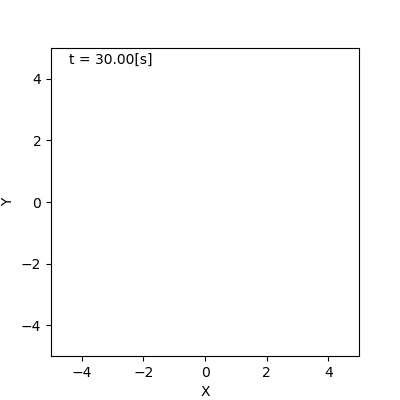

In [16]:
world = World(30, 0.1)

for i in range(100):
    circling = Agent(0.2, 10.0/180*math.pi)
    r = Robot(np.array([0,0,0]).T, sensor=None,agent=circling)
world.draw()

In [17]:
class Robot(IdealRobot):
    
    def __init__(self, pose, agent=None, sensor=None, color="black", noise_per_meter=5, noise_std=math.pi/60):
    
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100+noise_per_meter))
        self.distance_util_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
    
    def noise(self, pose, nu, omega, time_interval):
        self.distance_util_noise -=abs(nu)*time_interval+ self.r*abs(omega)*time_interval
        if self.distance_util_noise<=0.0:
            self.distance_util_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
        
        return pose
        
    def one_step(self, time_interval):
        if not self.agent:return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


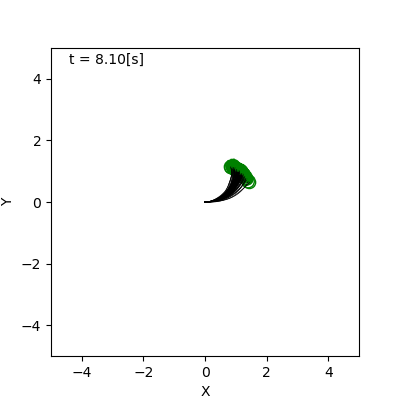

In [18]:
world = World(30, 0.1)
for i in range(100):
    circling=Agent(0.2, 10.0/180*math.pi)
    r = Robot(np.array([0,0,0]).T, sensor=None, agent=circling, color="g")
    world.append(r)
    
world.draw()

In [7]:
#移動速度へのバイアスの実装


In [19]:
class Robot(IdealRobot):
    
    def __init__(self, pose, agent=None, sensor=None, color="black", noise_per_meter=5, noise_std=math.pi/60, \
                    bias_rate_stds=(0.1, 0.1)):
    
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100+noise_per_meter))
        self.distance_util_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])
    
    def noise(self, pose, nu, omega, time_interval):
        self.distance_util_noise -=abs(nu)*time_interval+ self.r*abs(omega)*time_interval
        if self.distance_util_noise<=0.0:
            self.distance_util_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
        
        return pose
        
    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
        
    def one_step(self, time_interval):
        if not self.agent:return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


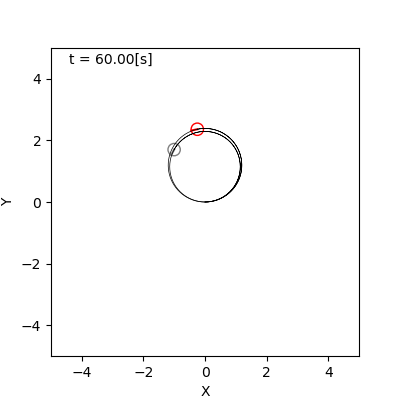

In [20]:
import copy

world = World(60,0.1)

circling = Agent(0.2, 10.0/180*math.pi)
nobias_robot = IdealRobot(np.array([0,0,0]).T, sensor=None, agent=circling, color="gray")
world.append(nobias_robot)
biased_robot = Robot(np.array([0,0,0]).T, sensor=None, agent=circling, color="red", noise_per_meter=0, bias_rate_stds=(0.2, 0.2))
world.append(biased_robot)

world.draw()

In [21]:
#スタックの実装

In [22]:
class Robot(IdealRobot):
    
    def __init__(self, pose, agent=None, sensor=None, color="black", noise_per_meter=5, noise_std=math.pi/60, \
                    bias_rate_stds=(0.1, 0.1),\
                    expected_stuck_time=1e100, expected_escapetime=1e-100
                ):
    
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100+noise_per_meter))
        self.distance_util_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        self.stuck_pdf = expon(scale=expected_stuck_time)
        self.escape_pdf = expon(scale=expected_escapetime)
        self.time_util_stuck = self.stuck_pdf.rvs()
        self.time_util_escape=self.escape_pdf.rvs()
        self.is_stuck=False
    
    def noise(self, pose, nu, omega, time_interval):
        self.distance_util_noise -=abs(nu)*time_interval+ self.r*abs(omega)*time_interval
        if self.distance_util_noise<=0.0:
            self.distance_util_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
        
        return pose
        
    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
        
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_util_stuck-=time_interval
            if self.time_util_escape<=0.0:
                self.time_util_escape+=self.escape_pdf.rvs()
                self.is_stuck=False
            else:
                self.time_util_stuck-=time_interval
                if self.time_util_stuck <=0.0:
                    self.time_util_stuck+=self.stuck_pdf.rvs()
                    self.is_stuck=True
                    
        return nu*(not self.is_stuck), omega*(not self.is_stuck)
        
    def one_step(self, time_interval):
        if not self.agent:return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        if self.sensor: self.sensor.data(self.pose)

<IPython.core.display.Javascript object>


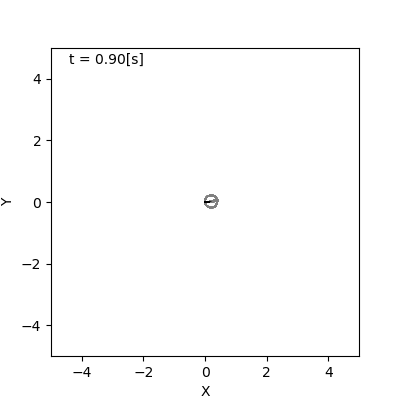

In [23]:
world = World(60,0.1)

circling = Agent(0.2, 10.0/180*math.pi)
for i in range(100):
    r=Robot(np.array([0,0,0]).T, sensor=None, agent=circling, color="gray", noise_per_meter=0, bias_rate_stds=(0,0,0,0), \
           expected_escapetime=60.0, expected_stuck_time=60.0)
    world.append(r)
r=IdealRobot(np.array([0,0,0]).T, sensor=None, agent=circling, color="r")
world.draw()

In [24]:
#誘拐の実装
from scipy.stats import expon, norm, uniform

In [25]:
class Robot(IdealRobot):
    
    def __init__(self, pose, agent=None, sensor=None, color="black", noise_per_meter=5, noise_std=math.pi/60, \
                    bias_rate_stds=(0.1, 0.1),\
                    expected_stuck_time=1e100, expected_escapetime=1e-100,
                    expected_kidnap_time=1e100, kidnap_range_x=(-5.0, 5.0), kidnap_range_y=(-5.0, 5.0)                ):
    
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100+noise_per_meter))
        self.distance_util_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])
        self.stuck_pdf = expon(scale=expected_stuck_time)
        self.escape_pdf = expon(scale=expected_escapetime)
        self.time_util_stuck = self.stuck_pdf.rvs()
        self.time_util_escape=self.escape_pdf.rvs()
        self.is_stuck=False
        self.kidnap_pdf = expon(scale=expected_kidnap_time)
        self.time_util_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist=uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0]))
    
    def noise(self, pose, nu, omega, time_interval):
        self.distance_util_noise -=abs(nu)*time_interval+ self.r*abs(omega)*time_interval
        if self.distance_util_noise<=0.0:
            self.distance_util_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
        
        return pose
        
    def bias(self, nu, omega):
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
        
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_util_stuck-=time_interval
            if self.time_util_escape<=0.0:
                self.time_util_escape+=self.escape_pdf.rvs()
                self.is_stuck=False
            else:
                self.time_util_stuck-=time_interval
                if self.time_util_stuck <=0.0:
                    self.time_util_stuck+=self.stuck_pdf.rvs()
                    self.is_stuck=True
                    
        return nu*(not self.is_stuck), omega*(not self.is_stuck)
        
        
        def kidnap(self, pose, time_interval):
            self.time_util_kidnap -=time_interval
            if self.time_util_kidnap<=0.0:
                self.time_util_kidnap+=self.kidnap_pdf.rvs()
                return np.array(self.kidnap_dist.rvs()).T
            else:
                return pose
        
    def one_step(self, time_interval):
        if not self.agent:return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval)

<IPython.core.display.Javascript object>


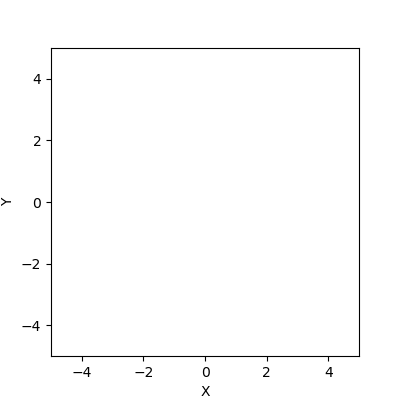

In [28]:
world = World(30, 0.1)
circling = Agent(0.2, 10.0/180*math.pi)
for i in range(100):
    for i in range(100):
        r=Robot(np.array([0,0,0]).T, sensor=None, agent=circling, color="gray", noise_per_meter=0, bias_rate_stds=(0,0,0,0), expected_kidnap_time=5)
        world.append(r)
        
r = IdealRobot(np.array([0,0,0]).T, sensor=None, agent=circling, color="red")
world.append(r)
world.draw()
        